# 1. 加载数据集 MNIST

In [1]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(), # value of pixel: [0, 255] -> [0, 1]
    transforms.Normalize(mean = (0.5,), std = (0.5,)) # value of tensor: [0, 1] -> [-1, 1]
])
mnist = datasets.MNIST(root='data', train=True, download=True, transform=transform)

`transforms.Normalize()`用于将图像进行标准化：$\rm{\frac{(x - mean)}{std}}$，使得处理的数据呈正态分布。

由于 MNIST 数据集图像为灰度图只有一个通道，因此只需要设置单个通道的 mean 与 std 即可。

这里的取值，可以是将图像像素值[0,255] 缩放至 [0, 1]后求得均值和方差，也可以是根据经验设置，即 mean=0.5, std=0.5。

# 2. 查看数据

In [2]:
img, label = mnist[len(mnist)-500]
print(f"Label: {label}")
print(f"Some pixel values: {img[0, 10:15, 10:15]}")
print(f"Min value: {img.min()}, Max value: {img.max()}")

Label: 3
Some pixel values: tensor([[-0.9451, -0.6392, -0.9843, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -0.9529, -0.7725],
        [-1.0000, -0.8745, -0.0196,  0.5765,  0.7725],
        [-1.0000,  0.0902,  0.9922,  0.9922,  0.9922],
        [-1.0000, -0.3569,  0.1216,  0.1216, -0.5686]])
Min value: -1.0, Max value: 1.0


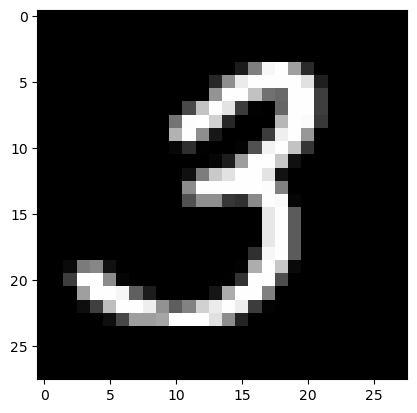

In [3]:
import matplotlib.pyplot as plt
import torch
def dnorm(x:torch.Tensor):
    min_value = -1
    max_value = 1
    out = (x - min_value) / (max_value - min_value)
    return out.clamp(0,1)   # plt expects values in [0,1]

img_norm = dnorm(img)   # shape: (1, 28, 28)
plt.imshow(img_norm.squeeze(0), cmap='gray')

# 3. 制作数据加载器Dataloader

In [4]:
from torch.utils.data import DataLoader
batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

# 4. 创建GAN的生成器与判别器并测试

In [5]:
from model import Generator, Discriminator

image_size = 28 * 28
hidden_size = 256
latent_size = 64

G = Generator(image_size=image_size, hidden_size=hidden_size, latent_size=latent_size)
D = Discriminator(image_size=image_size, hidden_size=hidden_size)

Result from Discriminator: 0.5166


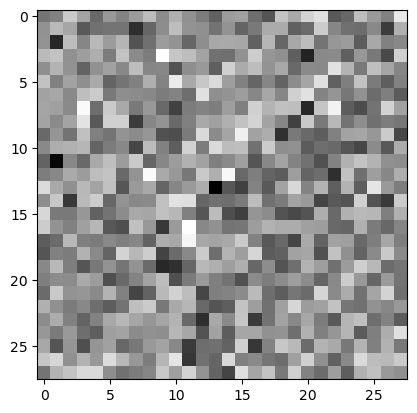

In [6]:
untrained_G_out = G(torch.randn(latent_size))  # Shape: [latent_size]
untrained_D_out = D(untrained_G_out.view(1, -1))
print(f"Result from Discriminator: {untrained_D_out.item():.4f}")
plt.imshow(untrained_G_out.view(28, 28).detach(), cmap='gray')

# 5. 对抗训练模型

In [7]:
from torch import optim
from torch import nn
num_epochs = 300
device = "cuda:0" if torch.cuda.is_available() else "cpu"
D.to(device=device)
G.to(device=device)

d_optim = optim.Adam(D.parameters(), lr=0.002)
g_optim = optim.Adam(G.parameters(), lr=0.002)

criterion = nn.BCELoss()

d_loss_list, g_loss_list, real_score_list, fake_score_list = ([] for _ in range(4))

In [8]:
from training import run_epoch, generate_and_save_images

image_prefix = "./sample"

for epoch in range(num_epochs):
    run_epoch(d_net=D, g_net=G, 
              train_loader=data_loader, criterion=criterion, 
              d_optim=d_optim, g_optim=g_optim,
              batch_size=batch_size, latent_size=latent_size, device=device,
              d_loss_list=d_loss_list, g_loss_list=g_loss_list,
              real_score_list=real_score_list, fake_score_list=fake_score_list, 
              epoch=epoch, num_epochs=num_epochs)
    if (epoch+1) % 10 == 0:
        if generate_and_save_images(g_net=G, batch_size=batch_size, 
                                 latent_size=latent_size, device=device, 
                                 image_prefix=image_prefix, index=epoch+1):

            print(f"Generated images at epoch {epoch+1}")


Epoch: [1/300], Batch: [300/600]Discriminator Loss: 1.1440, Generator Loss: 0.5215
Epoch: [1/300], Batch: [300/600]Real sample score for Discriminator D(x): 0.8644
Epoch: [1/300], Batch: [300/600]Fake sample score for Discriminator D(G(x)): 0.6283
Epoch: [1/300], Batch: [600/600]Discriminator Loss: 1.3556, Generator Loss: 0.8904
Epoch: [1/300], Batch: [600/600]Real sample score for Discriminator D(x): 0.9466
Epoch: [1/300], Batch: [600/600]Fake sample score for Discriminator D(G(x)): 0.6932
Epoch: [2/300], Batch: [300/600]Discriminator Loss: 1.3900, Generator Loss: 0.6361
Epoch: [2/300], Batch: [300/600]Real sample score for Discriminator D(x): 0.9253
Epoch: [2/300], Batch: [300/600]Fake sample score for Discriminator D(G(x)): 0.7096
Epoch: [2/300], Batch: [600/600]Discriminator Loss: 1.0087, Generator Loss: 0.6839
Epoch: [2/300], Batch: [600/600]Real sample score for Discriminator D(x): 0.8953
Epoch: [2/300], Batch: [600/600]Fake sample score for Discriminator D(G(x)): 0.5827
Epoch: [

# 6. 保存checkpoint

In [9]:
import os
checkpoint_path = "./checkpoints"

if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
torch.save(G.state_dict(), os.path.join(checkpoint_path, "G.pt"))
torch.save(D.state_dict(), os.path.join(checkpoint_path, "D.pt"))

# 7. 检查训练结果
## 损失变化与判别器评判分数

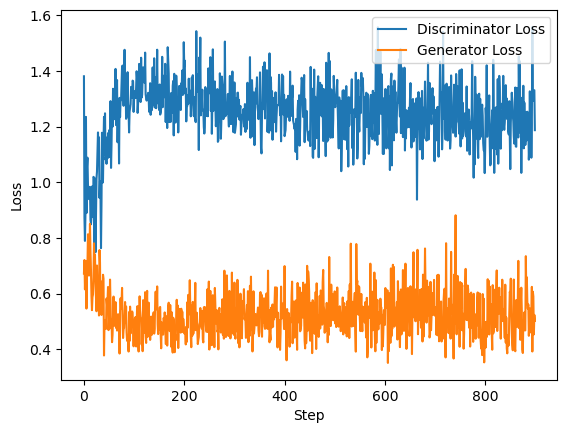

In [18]:
plt.plot(d_loss_list[::200], label="Discriminator Loss")
plt.plot(g_loss_list[::200], label="Generator Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
plt.show()

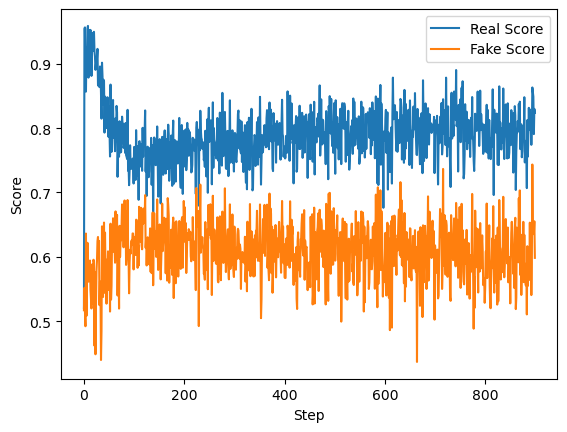

In [19]:
plt.plot(real_score_list[::200], label="Real Score")
plt.plot(fake_score_list[::200], label="Fake Score")
plt.xlabel("Step")
plt.ylabel("Score")
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
plt.show()

## 生成的图像

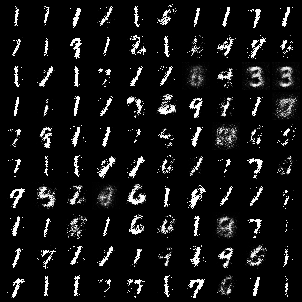

In [22]:
from IPython.display import Image
Image(os.path.join(image_prefix, "fake_images-010.png"))

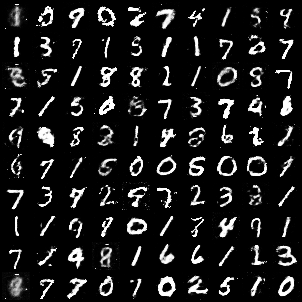

In [23]:
Image(os.path.join(image_prefix, "fake_images-300.png"))